# `nb07`: Variational inference

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy as jsc

In [2]:
import wandb
from tqdm import tqdm

# The pitcher's example

In [3]:
# Gaussian mean-field variational parameterization
def vp_init(size):
    mu = np.random.randn(size)
    log_s = np.random.randn(size)  # omega
    return jnp.array([mu, log_s])

def eps_rvs(size, n=1):
    return np.random.randn(n, size)

def zeta(vp, eps):
    mu = vp[0]
    s = jnp.exp(vp[1])
    return mu + s * eps   

def entropy_q(vp):
    K = len(vp[0])
    return K / 2. * (1. + np.log(2 * np.pi)) + jnp.sum(vp[1]) 

In [4]:
# Transformation from bounded to real
def sigmoid(x):
    return 1. / (1. + jnp.exp(-x))
    
def T(z, a, b):
    zeta = jsc.special.logit((z - a) / (b - a))
    return zeta

def T_inv(zeta, a, b):
    z = a + (b - a) * sigmoid(zeta)
    return z
    
def det_jac_T_inv(zeta, a, b):
    return (b - a) * sigmoid(zeta) * (1 - sigmoid(zeta))

In [5]:
# Prior
def log_prior_v(v):
    return jnp.log(1. / 10)

def log_prior_alpha(alpha):
    return jnp.log(2. / np.pi)

In [6]:
# Likelihood
def _trajectory(v, alpha, dt=0.1, G=9.81):
    v_x = v * jnp.cos(alpha)  # x velocity m/s
    v_y = v * jnp.sin(alpha)  # y velocity m/s
    
    x = 0.0  # initial position
    y = 1.5  # initial height

    while y > 0:  # simulate until ball hits floor
        v_y += dt * -G  # acceleration due to gravity
        x += dt * v_x
        y += dt * v_y
        
    return x, y

def log_likelihood(x_obs, v, alpha, sigma=0.5):
    mu, _ = _trajectory(v, alpha)
    return -0.5 * ((x_obs - mu) / sigma) ** 2 - jnp.log(sigma * (2. * np.pi) ** 0.5)

In [7]:
def elbo(vp, x_obs, eps):
    _zeta = zeta(vp, eps)
    out = 0.0
    
    # log p(v)
    v = T_inv(_zeta[0], 0., 10.)
    out += log_prior_v(v)
    out += jnp.log(det_jac_T_inv(_zeta[0], 0., 10.))
    
    # log p(alpha)
    alpha = T_inv(_zeta[1], 0., np.pi / 2)
    out += log_prior_alpha(alpha)
    out += jnp.log(det_jac_T_inv(_zeta[1], 0., np.pi / 2.))
    
    # log p(x|v, alpha)
    out += log_likelihood(x_obs, v, alpha)
    
    # entropy q
    out += entropy_q(vp)
    
    return jnp.sum(out) 

grad_elbo = jax.grad(elbo)

In [8]:
v_true = 7.5
alpha_true = np.pi / 4
mu, _ = _trajectory(v_true, alpha_true)
x_obs = np.random.randn(1) * 0.5 + mu
x_obs = x_obs[0]

vp = vp_init(2)
batchsize = 25
lr = 0.02
n_epochs = 50

wandb.init(project="nb08-advi")
wandb.config.update({
    "v_true": v_true, "alpha_true": alpha_true, "x_obs": x_obs,
    "lr": lr, "batchsize": batchsize
})

I0000 00:00:1701026145.818482  139325 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: glouppe. Use `wandb login --relogin` to force relogin


In [9]:
test = eps_rvs(2, 100)
g = grad_elbo(vp, x_obs, test[0])

for epoch in tqdm(range(n_epochs)):
    # Log
    elbo_test = np.mean([elbo(vp, x_obs, eps) for eps in test])
    wandb.log({"ELBO": elbo_test})
    
    # Update            
    g = jnp.zeros_like(g)
    
    for eps in eps_rvs(2, batchsize):
        g += grad_elbo(vp, x_obs, eps)
    
    vp += lr * g / batchsize

100%|██████████| 50/50 [01:12<00:00,  1.46s/it]


In [10]:
_zeta = zeta(vp, eps_rvs(2, 10000))
v = T_inv(_zeta[:, 0], 0., 10.)
alpha = T_inv(_zeta[:, 1], 0., np.pi / 2.)

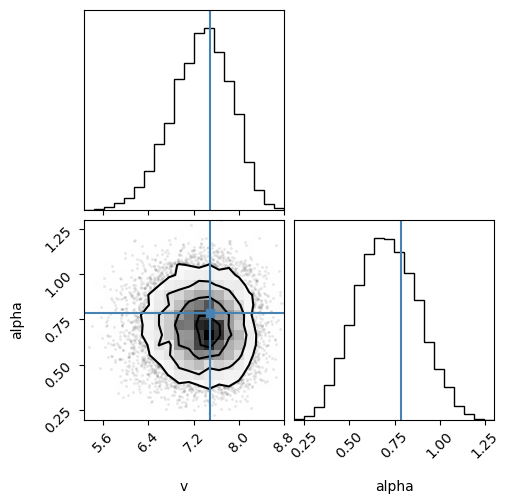

In [11]:
import corner
thetas = np.array([v, alpha]).T
labels = ["v", "alpha"]
fig = corner.corner(thetas, labels=labels, truths=[v_true, alpha_true])

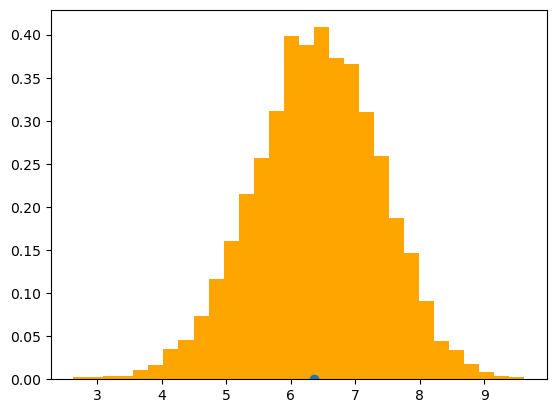

In [12]:
# p(x | x_obs)
xs = []
    
for v, alpha in thetas[:5000]:
    mu, _ = _trajectory(v, alpha)   
    x = np.random.randn(1) * 0.5 + mu
    xs.append(x[0])

plt.hist(xs, density=True, bins=30, color="orange")
plt.scatter([x_obs], [0.])
plt.show()